In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
from copy import deepcopy
from sklearn.model_selection import KFold
from torch.utils.data import Subset,Dataset,DataLoader
import pandas as pd
import cv2
from torchvision import models
from torchvision.models import VGG16_Weights

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score



In [2]:
number_videos = 0
number_frames = 5
batch_size = 40

In [3]:
# path = kagglehub.dataset_download("hhalalwi/deepfake-face-mask-dataset-dffmd")
path = "data"
print("Path to dataset files:", path)

Path to dataset files: data


In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [5]:
data = []

for folder in os.listdir(path):
  if folder == "Fake" or folder == "Real":
    for file in os.listdir(os.path.join(path,folder,folder)):
      if folder == "Fake":
        data.append([os.path.join(path,folder,folder,file),0])
      else:
        data.append([os.path.join(path,folder,folder,file),1])
data = np.array(data)
np.random.shuffle(data)
len(data)

1836

In [ ]:
class VideoDataset(Dataset):
    def __init__(self,data,number_frames):
        self.data = []
        self.labels = []
        for i in data:
            self.data.append(i[0])
            self.labels.append(i[1])
        self.number_frames = number_frames
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        frames = self.get_frames(self.data[idx])
        return np.array(frames),int(self.labels[idx])

    def get_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        
        total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frame_count - 1, self.number_frames, dtype=int)
        frames = []
    
        for index in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()
    
            while not ret and index < total_frame_count - 1:
                index += 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, index)
                ret, frame = cap.read()
    
            if not ret:
                break 
            
            frame = cv2.resize(frame, (244, 244))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
        cap.release()
    
        if frames:
            while len(frames) < self.number_frames:
                frames.append(frames[-1].copy())
        else:
            raise ValueError("No frames were successfully extracted from the video.")
    
        return frames


In [7]:
def get_data(data,number_frames,number_videos=0):
    if number_videos == 0:
      vidoes_dataset = VideoDataset(data,number_frames)
      return vidoes_dataset
    else:
      data = data[:number_videos]
      vidoes_dataset = VideoDataset(data,number_frames)
      data_frames = []
      labels = []

      for i in tqdm(range(len(vidoes_dataset))):
        frames,label = vidoes_dataset[i]
        data_frames.append(frames)
        labels.append(int(label))

      data_frames = np.array(data_frames)
      print(data_frames.shape)
      return (data_frames,labels)


In [8]:
dataset = get_data(data,number_frames,number_videos)

In [9]:
conv = models.vgg16(weights=VGG16_Weights.DEFAULT)
list(conv.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)

        for layer in vgg16.parameters():
          layer.requires_grad = False

        self.model = nn.Sequential(*list(vgg16.children())[:-2])
        self.avgPooling = nn.MaxPool2d(7)
        self.lstm = nn.LSTM(512, 512,2 , batch_first=True)

        self.linear1 = nn.Linear(512,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,1)
        
    def forward(self,x):
         batch_size, num_frames, channels, height, width = x.size()
         x = x.view(batch_size * num_frames, channels, height, width)
         x = self.model(x)
         x = self.avgPooling(x)

         x = x.reshape(batch_size, -1)
         x = x.reshape(batch_size,num_frames,-1)


         lstm_out, _= self.lstm(x)


         x = lstm_out[:,-1,:]


         x = x.reshape(batch_size, -1)

         x = F.relu(self.linear1(x))
         
         x = F.relu(self.linear2(x))

         x = F.sigmoid(self.linear3(x))


         return x

In [11]:
def train(data,epoch ,model,optimizer,loss_fun):

    total_loss = []
    model.train()
    for ep in tqdm(range(epoch)):
      if number_videos !=0:
        optimizer.zero_grad()
        x = torch.tensor(data[0]).to(device)

        x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
        x = x.float()

        target = torch.tensor(data[1]).to(device)
        target = target.float()
        target = target.unsqueeze(-1)
        outputs = model(x)
        loss = loss_fun(outputs,target)
        loss.backward()
        optimizer.step()

      else:
        for i, (x, target) in enumerate(data):
            optimizer.zero_grad()

            target = torch.tensor(target)
            target = target.float()
            x = torch.tensor(x)

            x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
            x = x.float()

            target = target.to(device)
            x= x.to(device)

            outputs = model(x)

            loss = loss_fun(outputs,target)
            loss.backward()
            optimizer.step()
      total_loss.append(float(loss))


    return total_loss

In [12]:
class GreyWolfOA:
    def __init__(self, n=5,i=100):
        self.population_size = n
        self.iterations = i
    def fittness(self, population,is_fittness_calculated,previous_fittness_values):
        population = np.array(population)
        values = []
        i=0
        print("fittness: ")
        for index,sample in enumerate(population):
          if is_fittness_calculated[index]:
            values.append(previous_fittness_values[index])
            continue
          elif population[index]<0:
            values.append(10000000)
            continue
          else:
            print("lr: ",population[index])
            model = CNN().to(self.device)
            optimizer = torch.optim.Adam(model.parameters(),lr= sample)
            loss_fun = nn.BCELoss()
            history = train(self.data,10,model,optimizer,loss_fun)
            # print(np.array(history["loss"][-5:]).mean())
            values.append(np.array(history[-5:]).mean())
            i+=1
            is_fittness_calculated[index] = True
        return values , is_fittness_calculated

    def calc_singleX(self,a,sample_i, wolf):#wolf = (alpha,beta,gamma)
        random1,random2 = np.random.uniform(0.00001,0.001),np.random.uniform(0.00001,0.001)
        A = (2*a* random1) - a
        B = 2* random2
        C = np.abs(B* wolf - sample_i)
        x = wolf - A*C
        # print("random 1 ",random1)
        # print("random 2 ",random2)
        # print("a ",a)
        # print("A ",A)
        # print("b ",B)
        # print("c ",C)
        # print("x ",x)
        # print("wolf ",wolf)
        # print('==========================')

        return x

    def fit(self,data,device):
        self.data = data
        self.device = device

        population = np.random.uniform(0.00001,0.001,size=self.population_size)
        is_fittness_calculated= [False for _ in range(self.population_size)]
        history = []
        previous_fittness_values = []
        for i in range(self.iterations):

            fitness_values,is_fittness_calculated = self.fittness(population,is_fittness_calculated,previous_fittness_values)
            indecies = np.argsort(fitness_values)

            alpha = population[indecies[0]]
            beta = population[indecies[1]]
            gamma = population[indecies[2]]
            a = 2 *(1-(i /self.iterations))**30

            for sample in range(self.population_size):
                x1 = self.calc_singleX(a,sample,alpha)
                x2 = self.calc_singleX(a,sample,beta)
                x3 = self.calc_singleX(a,sample,gamma)


                new_x = (x1+x2+x3)/3
                new_fittness,_= self.fittness([new_x],[False],[0])
                if fitness_values[sample] > new_fittness[0]:
                    population[sample] = new_x
                    fitness_values[sample]= new_fittness[0]
                    is_fittness_calculated[sample]=True

            previous_fittness_values= deepcopy(fitness_values)

            indecies = np.argsort(fitness_values)
            history.append([population[indecies[0]],fitness_values[indecies[0]]])
            print("-----------alpha is: ",population[indecies[0]],"loss: ",fitness_values[indecies[0]])
            print('-----------------------------------------------------------')
            print(f'Iteration {i+1}population: {population}')
        return population[indecies[0]],history

In [18]:
greywolf = GreyWolfOA(5,10)
alpha , history = greywolf.fit(dataset,device) 

fittness: 
lr:  0.0007925274335762672


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


lr:  0.00032078510178969004


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


lr:  6.060034067327048e-05


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


lr:  0.0005846554325760986


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


lr:  0.0003382855271981477


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


fittness: 
lr:  0.0005673810294946955


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


fittness: 
lr:  1.9983158730466517


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


fittness: 
lr:  3.9981907891104704


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


fittness: 
lr:  5.995445208138232


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


fittness: 
lr:  7.988628182060791


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


-----------alpha is:  0.0007925274335762672 loss:  0.17345837131142616
-----------------------------------------------------------
Iteration 1population: [7.92527434e-04 3.20785102e-04 6.06003407e-05 5.84655433e-04
 3.38285527e-04]
fittness: 
fittness: 
lr:  0.0005660482968357031


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


fittness: 
lr:  0.08527400062573255


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


fittness: 
lr:  0.16997386075033313


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


fittness: 
lr:  0.2546181305710391


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


fittness: 
lr:  0.3394564426956744


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


-----------alpha is:  0.0007925274335762672 loss:  0.17345837131142616
-----------------------------------------------------------
Iteration 2population: [7.92527434e-04 3.20785102e-04 6.06003407e-05 5.84655433e-04
 3.38285527e-04]
fittness: 
fittness: 
lr:  0.0005659907225809627


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


fittness: 
lr:  0.003040038874890486


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


fittness: 
lr:  0.005512294828111076


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


fittness: 
lr:  0.007989637560776497


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


fittness: 
lr:  0.0104565121407338


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


-----------alpha is:  0.003040038874890486 loss:  0.01244812894219649
-----------------------------------------------------------
Iteration 3population: [0.00079253 0.00304004 0.00551229 0.00058466 0.00033829]
fittness: 
fittness: 
lr:  0.0014724072947835305


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


fittness: 
lr:  0.00151743225058358


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


fittness: 
lr:  0.001562470865860777


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


fittness: 
lr:  0.0016075041305125416


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


fittness: 
lr:  0.0016526613183782035


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


-----------alpha is:  0.003040038874890486 loss:  0.01244812894219649
-----------------------------------------------------------
Iteration 4population: [0.00147241 0.00304004 0.00156247 0.0016075  0.00165266]
fittness: 
fittness: 
lr:  0.002039983434928882


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


fittness: 
lr:  0.0020404252638104112


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


fittness: 
lr:  0.002040867015750188


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


fittness: 
lr:  0.002041309239822295


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


fittness: 
lr:  0.0020417504421325543


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


-----------alpha is:  0.003040038874890486 loss:  0.01244812894219649
-----------------------------------------------------------
Iteration 5population: [0.00147241 0.00304004 0.00204087 0.00204131 0.00204175]
fittness: 
fittness: 
lr:  0.0023743661856202945


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


fittness: 
lr:  0.002374368046307941


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


fittness: 
lr:  0.002374369909175755


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


fittness: 
lr:  0.00237437177021324


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


fittness: 
lr:  0.0023743736312872034


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


-----------alpha is:  0.0023743736312872034 loss:  0.005935157685235027
-----------------------------------------------------------
Iteration 6population: [0.00237437 0.00304004 0.00237437 0.00237437 0.00237437]
fittness: 
fittness: 
lr:  0.002596260805117821


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


fittness: 
lr:  0.002596260807421836


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


fittness: 
lr:  0.0025962608097259356


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


fittness: 
lr:  0.002596260812024456


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


fittness: 
lr:  0.0025962608143278326


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


-----------alpha is:  0.002596260805117821 loss:  0.005429793443181552
-----------------------------------------------------------
Iteration 7population: [0.00259626 0.00304004 0.00237437 0.00237437 0.00237437]
fittness: 
fittness: 
lr:  0.00244833478186026


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


fittness: 
lr:  0.002448334781860671


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


fittness: 
lr:  0.0024483347818610827


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


fittness: 
lr:  0.0024483347818614943


100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


fittness: 
lr:  0.002448334781861905


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


-----------alpha is:  0.002596260805117821 loss:  0.005429793443181552
-----------------------------------------------------------
Iteration 8population: [0.00259626 0.00244833 0.00237437 0.00237437 0.00237437]
fittness: 
fittness: 
lr:  0.002472989739421899


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


fittness: 
lr:  0.002472989739421899


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


fittness: 
lr:  0.002472989739421899


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


fittness: 
lr:  0.002472989739421899


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


fittness: 
lr:  0.002472989739421899


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


-----------alpha is:  0.002596260805117821 loss:  0.005429793443181552
-----------------------------------------------------------
Iteration 9population: [0.00259626 0.00244833 0.00247299 0.00237437 0.00237437]
fittness: 
fittness: 
lr:  0.0024812080586089744


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


fittness: 
lr:  0.0024812080586089744


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


fittness: 
lr:  0.0024812080586089744


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


fittness: 
lr:  0.0024812080586089744


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


fittness: 
lr:  0.0024812080586089744


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]

-----------alpha is:  0.002596260805117821 loss:  0.005429793443181552
-----------------------------------------------------------
Iteration 10population: [0.00259626 0.00244833 0.00247299 0.00237437 0.00237437]


In [12]:
def evaluate_model(model, loss_fun,data_loader):
  model.eval()
  data_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    if number_videos !=0:
        train,labels = data_loader
        x, y = torch.tensor(train).to(device), torch.tensor(labels).to(device)
        x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
        x = x.float()

        outputs = model(x)
        y = y.float()
        y = y.unsqueeze(-1)

        loss = loss_fun(outputs, y)
        data_loss += loss.item()
        for t in range(len(outputs)):
          if outputs[t] >= 0.5 and y[t]==1:
            correct+= 1
            total+=1
          elif outputs[t] < 0.5 and y[t]==0:
            correct += 1
            total+=1
          else:
            total+=1
    else:
      for i,(x, y) in enumerate(data_loader):
          x, y = x.clone().detach().to(device), y.clone().detach().to(device)
          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()
          outputs = model(x)
          y = y.float()
          y = y.unsqueeze(-1)

          loss = loss_fun(outputs, y)
          data_loss += loss.item()
          for t in range(len(outputs)):
            if outputs[t] >= 0.5 and y[t]==1:
              correct+= 1
              total+=1
            elif outputs[t] < 0.5 and y[t]==0:
              correct += 1
              total+=1
            else:
              total+=1
          predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          correct += (predicted == y.cpu().numpy()).sum().item()
          total += y.size(0)


  data_loss /= len(data_loader)
  val_accuracy = correct / total
  return data_loss, val_accuracy

def train_cross_validation(data,epoch):

    k_folds = 3
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_results=[]
    models_details=[]

    if number_videos !=0:
      splited_data = data[0]
    else:
      splited_data = data

    for fold_number,(train_idx,val_idx) in enumerate(kf.split(splited_data)):

      if number_videos != 0:
        train_videos = np.array(data[0])[train_idx]
        train_labels = np.array(data[1])[train_idx]

        val_videos = np.array(data[0])[val_idx]
        val_labels = np.array(data[1])[val_idx]

      else:
        train_subset = Subset(splited_data, train_idx)
        val_subset = Subset(splited_data, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

      model = CNN().to(device)
      optimizer = torch.optim.Adam(model.parameters(),lr=0.002596260805117821    )
      loss_fun = nn.BCELoss()

      print(f"fold {fold_number+1}/3: ----------------------------- ")
      total_loss = []
      model.train()
      # for ep in range(epoch):
      if number_videos !=0:
        for ep in range(epoch):
          optimizer.zero_grad()
          x = torch.tensor(train_videos).to(device)

          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()

          target = torch.tensor(train_labels).to(device)
          target = target.float()
          target = target.unsqueeze(-1)
          outputs = model(x)
          loss = loss_fun(outputs,target)
          loss.backward()
          optimizer.step()
          print(f"\rEpoch {ep+1}, loss: {loss.item():.8f}",end="")
          total_loss.append(float(loss))
          
      else:
          for i, (x, target) in enumerate(train_loader):
          # target = target.clone().detach().requires_grad_(True)
              target = target.clone().detach()
              target = target.float()
    
              x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
              x = x.float()    
              target = target.to(device).unsqueeze(-1)
              x= x.to(device)
              for ep in range(epoch):
                  optimizer.zero_grad()
    
    
                  outputs = model(x)
    
                  loss = loss_fun(outputs,target)
                  loss.backward()
                  optimizer.step()
                  print(f"\rEpoch {ep+1}, loss: {loss.item():.8f}, [{i}/{len(train_loader)}]",end="")
                  total_loss.append(float(loss))


      if number_videos != 0:
        loss,accuracy = evaluate_model(model,loss_fun,(val_videos,val_labels))
        y_true = val_labels
        y_predict = predict(model,val_videos)
      else:
        # loss,accuracy = evaluate_model(model,loss_fun,val_loader)
        y_true,y_predict = predict(model,val_loader)
      models_details.append(
      {
      "loss":total_loss,
      # "accuracy":accuracy,
      #  "precision":precision_score(y_true,y_predict),
      # "recall":recall_score(y_true,y_predict),
      # "f1":f1_score(y_true,y_predict),
      "classification": classification_report(y_true,y_predict,zero_division=0)
      }
      )
      print(classification_report(y_true,y_predict,zero_division=0))
      print()
      print(f"Fold {fold_number + 1}, loss: {float(loss)}")
      print("-----------------------------------------------------------------------------------------------------")
      # fold_results.append((val_loss, accuracy))
      # if fold_number==0:
      #   break

    return models_details

def predict(model,data):
    
     model.eval()
     with torch.no_grad():
        if number_videos !=0:
          x = torch.tensor(data).to(device)

          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()

          outputs = model(x)
          outputs = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          return outputs.squeeze()
        else:
          actual = []
          predicteds=[]
          for i,(x, y) in enumerate(data):
    
            x, y = x.clone().detach().to(device), y.clone().detach().to(device)
            y = y.unsqueeze(-1)
            x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
            x = x.float()
            
            outputs = model(x)
            predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
            actual.extend(list(y.cpu()))        
            predicteds.extend(list(predicted))        
        return np.array(actual).reshape(-1),np.array(predicteds).reshape(-1)


In [13]:
models_details=[]
history = train_cross_validation(dataset,5)

fold 1/3: ----------------------------- 
Epoch 5, loss: 0.00418910, [30/31]              precision    recall  f1-score   support

           0       0.88      0.98      0.93       325
           1       0.98      0.85      0.91       287

    accuracy                           0.92       612
   macro avg       0.93      0.92      0.92       612
weighted avg       0.93      0.92      0.92       612


Fold 1, loss: 0.004189095925539732
-----------------------------------------------------------------------------------------------------
fold 2/3: ----------------------------- 
Epoch 5, loss: 0.00781494, [30/31]              precision    recall  f1-score   support

           0       0.98      0.89      0.93       338
           1       0.88      0.98      0.93       274

    accuracy                           0.93       612
   macro avg       0.93      0.94      0.93       612
weighted avg       0.94      0.93      0.93       612


Fold 2, loss: 0.007814938202500343
----------------------

In [15]:
for i in range(3):
  print(f"model number {i} ===================================")
  # print("recall: ",history[i]["recall"])
  # print("precision: ",history[i]["precision"])
  # print("f1: ",history[i]["f1"])
  # print("accuracy: ",history[i]["accuracy"])
  print("classification: ",history[i]["classification"])
  print("===================================================")

model number 0 ===================================
classification:                precision    recall  f1-score   support

           0       0.88      0.98      0.93       325
           1       0.98      0.85      0.91       287

    accuracy                           0.92       612
   macro avg       0.93      0.92      0.92       612
weighted avg       0.93      0.92      0.92       612

model number 1 ===================================
classification:                precision    recall  f1-score   support

           0       0.98      0.89      0.93       338
           1       0.88      0.98      0.93       274

    accuracy                           0.93       612
   macro avg       0.93      0.94      0.93       612
weighted avg       0.94      0.93      0.93       612

model number 2 ===================================
classification:                precision    recall  f1-score   support

           0       0.86      0.99      0.92       337
           1       0.98      0.80

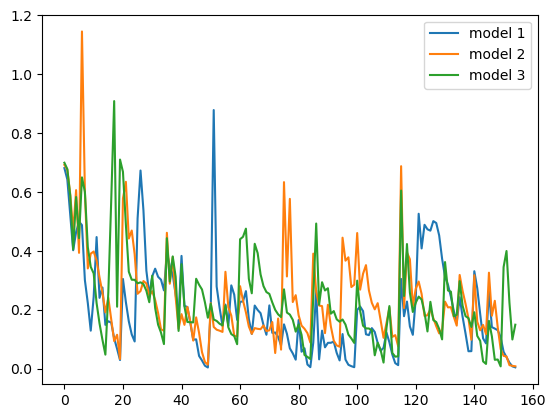

In [16]:
plt.plot(history[0]["loss"])
plt.plot(history[1]["loss"])
plt.plot(history[2]["loss"])
plt.legend(["model 1","model 2","model 3"])
plt.show()